<a href="https://colab.research.google.com/github/wulanika/klasifikasi-4-jenis-sendok/blob/main/Klasifikasi_4_Jenis_Kelas_Sendok_(Hyperparameter).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1. Install library
!pip install split-folders gdown

In [2]:
# 2. Download dataset dari Google Drive via link (tanpa mount)
import gdown
import zipfile
import os
from pathlib import Path
import random
import shutil

file_id = '14Ne047cR9Rnz7xMGya8ZJzGh9lDvWx1X'  # File ID dari Google Drive
gdown.download(f"https://drive.google.com/uc?id={file_id}", 'dataset.zip', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=14Ne047cR9Rnz7xMGya8ZJzGh9lDvWx1X
To: /content/dataset.zip
100%|██████████| 20.8M/20.8M [00:00<00:00, 83.1MB/s]


'dataset.zip'

In [3]:
# 3. Ekstrak isi ZIP
extract_path = Path("dataset/Dataset (resize)")
with zipfile.ZipFile("dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("dataset")

# 4. Split dataset
original_dataset_dir = extract_path
base_dir = Path("dataset/split_dataset")
train_dir = base_dir / "train"
val_dir = base_dir / "val"
test_dir = base_dir / "test"

# Buat folder train, val, test
for folder in [train_dir, val_dir, test_dir]:
    folder.mkdir(parents=True, exist_ok=True)

# Rasio
val_split = 0.2
test_split = 0.2

# Untuk setiap kelas
for class_dir in original_dataset_dir.iterdir():
    if class_dir.is_dir():
        images = list(class_dir.glob("*"))
        random.shuffle(images)

        class_name = class_dir.name
        total = len(images)
        val_count = int(total * val_split)
        test_count = int(total * test_split)
        train_count = total - val_count - test_count

        train_images = images[:train_count]
        val_images = images[train_count:train_count + val_count]
        test_images = images[train_count + val_count:]

        for subset, subset_images in zip(
            [train_dir, val_dir, test_dir],
            [train_images, val_images, test_images]
        ):
            class_subset_dir = subset / class_name
            class_subset_dir.mkdir(parents=True, exist_ok=True)
            for img in subset_images:
                shutil.copy(img, class_subset_dir)

print("✅ Dataset berhasil di-download, diekstrak, dan di-split ke train, val, dan test.")


✅ Dataset berhasil di-download, diekstrak, dan di-split ke train, val, dan test.


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import math

# Path direktori dataset
train_dir = '/content/dataset/split_dataset/train'
val_dir = '/content/dataset/split_dataset/val'
test_dir = '/content/dataset/split_dataset/test'

# Ukuran gambar dan batch
img_size = (224, 224)
batch_size = 50

# Data augmentation untuk training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.5,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validasi & Test: hanya normalisasi
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # supaya evaluasi akurat
)

# Info jumlah batch per epoch
print("Jumlah batch per epoch:")
print(f"Train: {math.ceil(train_generator.n / batch_size)}")
print(f"Validation: {math.ceil(val_generator.n / batch_size)}")
print(f"Test: {math.ceil(test_generator.n / batch_size)}")

# ===================
# Model CNN sederhana
# ===================
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator
)

# Evaluasi di test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"📊 Akurasi Test: {test_acc:.2f}")

# Simpan model
model.save('cnn_model_trained.h5')


Found 720 images belonging to 4 classes.
Found 240 images belonging to 4 classes.
Found 240 images belonging to 4 classes.
Jumlah batch per epoch:
Train: 15
Validation: 5
Test: 5
Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.2192 - loss: 1.6171 - val_accuracy: 0.3417 - val_loss: 1.3580
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 661ms/step - accuracy: 0.3291 - loss: 1.3434 - val_accuracy: 0.4417 - val_loss: 1.2207
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 576ms/step - accuracy: 0.4863 - loss: 1.1791 - val_accuracy: 0.5167 - val_loss: 1.1982
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 617ms/step - accuracy: 0.4950 - loss: 1.1102 - val_accuracy: 0.5167 - val_loss: 1.0624
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 631ms/step - accuracy: 0.5358 - loss: 1.0444 - val_accuracy: 0.5375 - val_loss: 1.0200
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 637ms/step - accuracy: 0.5578 - loss: 0.9981 - val_accuracy: 0.6042 - val_loss: 0.9989
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 605ms/step -

📊 Akurasi Test: 0.74


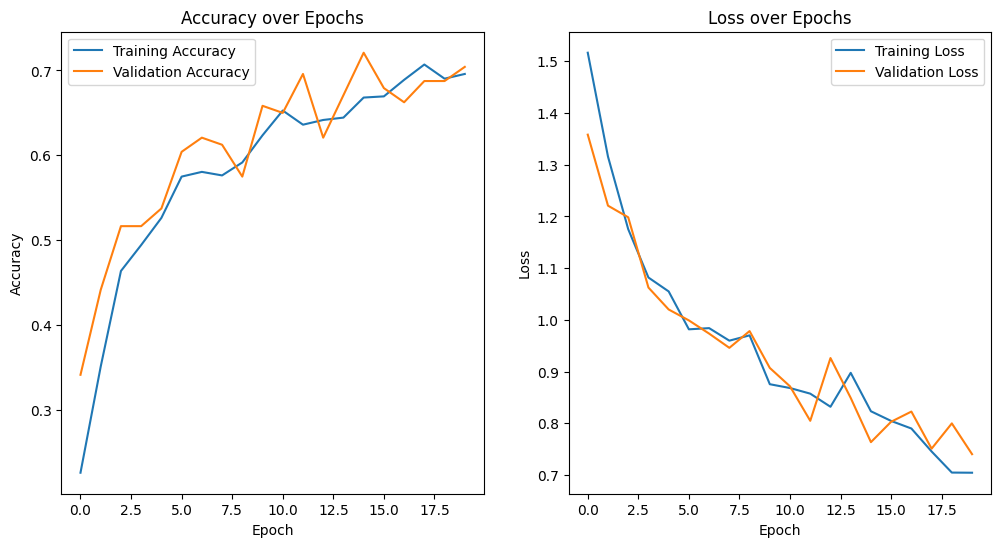

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


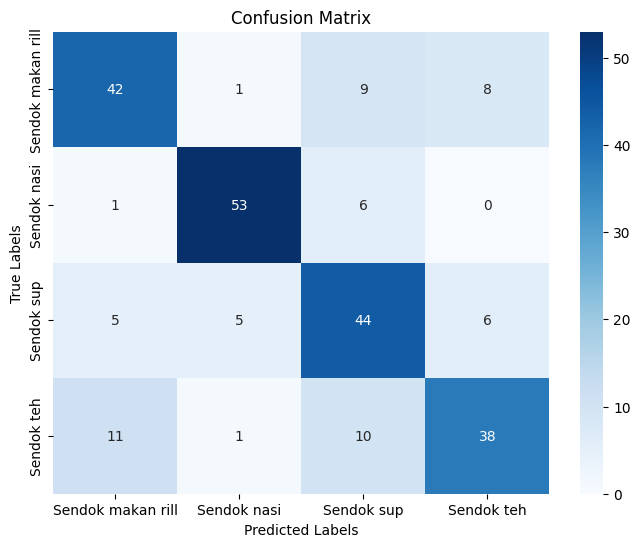

Classification Report:

                   precision    recall  f1-score   support

Sendok makan rill       0.71      0.70      0.71        60
      Sendok nasi       0.88      0.88      0.88        60
       Sendok sup       0.64      0.73      0.68        60
       Sendok teh       0.73      0.63      0.68        60

         accuracy                           0.74       240
        macro avg       0.74      0.74      0.74       240
     weighted avg       0.74      0.74      0.74       240



In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Visualisasi grafik akurasi dan loss
def plot_history(history):
    plt.figure(figsize=(12, 6))

    # Akurasi
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Tampilkan grafik history
plot_history(history)

# Prediksi data test
test_preds = model.predict(test_generator, verbose=1)
y_pred = np.argmax(test_preds, axis=1)
y_true = test_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification Report
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n")
print(report)


Saving 1744945808299.jpg to 1744945808299.jpg
📂 Memproses: 1744945808299.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


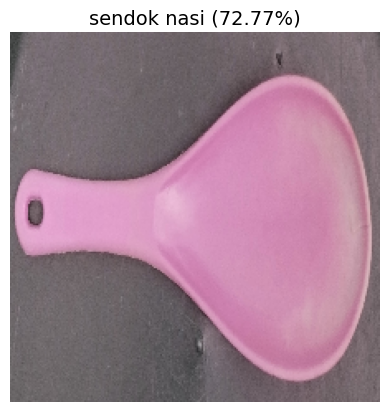

In [12]:
from keras.models import load_model
from keras.preprocessing import image
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
import json

# Load model
model = load_model('cnn_model_trained.h5')

# Daftar label kelas (HARUS sesuai urutan training)
# Bisa juga otomatis jika punya mapping dari train_generator.class_indices
class_labels = ['sendok makan', 'sendok nasi', 'sendok teh', 'sendok sup']

# Fungsi prediksi 1 gambar
def predict_uploaded_image(model, uploaded_file):
    # Load dan preprocess gambar
    img = image.load_img(uploaded_file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    # Prediksi
    prediction = model.predict(img_array)
    predicted_index = np.argmax(prediction)
    predicted_label = class_labels[predicted_index]
    confidence = prediction[0][predicted_index] * 100

    # Tampilkan gambar & hasil
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{predicted_label} ({confidence:.2f}%)", fontsize=14)
    plt.show()

# Upload gambar
uploaded = files.upload()

# Prediksi semua file yang diupload
for filename in uploaded.keys():
    print(f"📂 Memproses: {filename}")
    predict_uploaded_image(model, filename)
